In [1]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

import plotly.express as px
import plotly.graph_objects as go

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from fenginering.preprocessing import Crossover
from fenginering.preprocessing import Scale
from fenginering.get_data import *

import warnings

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
SYMBOLS = ['USDT', 'BTC', 'ETH', 'EGLD', 'QNT', 'BNB', 'KSM', 'XMR', 'AAVE']
SYMBOLS = ["QNT", "EGLD", "XMR"]

asset = SYMBOLS[2]
start = "2017"
end = "2023"

data = get_data(asset, '1d').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(1579, 5)

In [3]:
def get_classification_target(data):
    data = data.copy()
    data['returns'] = data["close"].pct_change()
    data['target'] = data['returns'].rolling(3).mean().shift(-1)
    #data['target'] = data['returns'].shift(-1)
    data['target'] = np.where(data['target'] > 0, 1, 0)
    return data['target']


#data['target'] = get_classification_target(data)
#data = data.iloc[:-1]

In [4]:
data['returns'] = data.close.pct_change()
data.dropna(inplace=True)

data['target'] = data['returns'].rolling(3).mean()
data['target'] = data['target'].shift(-2)
data.dropna(inplace=True)

data['target'] = np.where(data['target'] > 0, 1, 0)

data.head()

,open,high,low,close,volume,returns,target
time,,,,,,,
2019-03-16,52.10,54.89,52.10,53.35,8103.46093,0.023992,0
2019-03-17,53.56,53.57,51.54,52.36,3314.97426,-0.018557,0
2019-03-18,52.38,53.01,51.27,52.06,4037.80163,-0.005730,1
2019-03-19,51.93,54.00,51.61,52.90,6567.87086,0.016135,1
2019-03-20,52.83,54.60,52.41,54.19,8340.92803,0.024386,0


<AxesSubplot: >

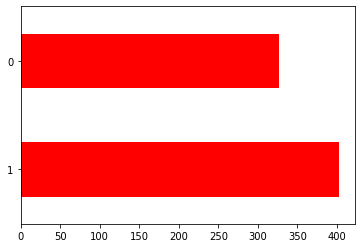

In [5]:
N = data.shape[0]
n = int(0.7*N)
train = data.loc["2021":"2022"]
test = data.loc["2023"]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

In [10]:
train

,open,high,low,close,volume,returns,target
time,,,,,,,
2021-01-01,156.20,169.09,130.23,135.81,361562.69100,-0.130649,0
2021-01-02,135.73,145.56,128.32,143.52,378478.37786,0.056770,0
2021-01-03,143.52,145.08,131.00,138.26,231236.74832,-0.036650,0
2021-01-04,138.24,143.90,128.72,133.79,222339.61750,-0.032330,1
2021-01-05,133.76,139.60,129.04,136.00,176543.99308,0.016518,1
...,...,...,...,...,...,...,...
2022-12-27,146.80,147.60,143.60,145.60,90577.72400,-0.007498,0
2022-12-28,145.60,147.00,143.60,146.80,64561.43100,0.008242,1
2022-12-29,146.80,147.00,144.00,145.60,76369.53800,-0.008174,1


In [6]:
lag_ret_list = [1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]


Indicators = MakeIndicator(features)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)


features = Indicators.transform()
date_range = features.index
target = target.loc[date_range]

In [7]:
features.head()

,open,high,low,close,volume,ret_1_0,ret_3_1,ret_5_2,ret_9_3,ret_15_4,ret_30_5,rsi_0,rsi_1,rsi_2
time,,,,,,,,,,,,,,
2021-01-31,139.44,140.45,132.17,137.73,81249.04002,-0.012192,0.016983,-0.000871,0.014287,-0.114618,0.014137,45.755400,46.385195,47.293641
2021-02-01,137.73,146.29,135.64,143.36,142330.81570,0.040877,0.021738,0.142766,0.031144,-0.102036,-0.001115,51.592332,50.532389,50.370249
2021-02-02,143.32,151.97,142.75,151.19,98757.06911,0.054618,0.084343,0.116370,0.095342,-0.036884,0.093519,58.493943,55.668348,54.277480
2021-02-03,151.20,155.24,150.15,154.60,107458.32209,0.022554,0.122486,0.101846,0.127151,-0.016977,0.155542,61.172643,57.726810,55.870159
2021-02-04,154.65,155.51,147.68,148.04,97493.70597,-0.042432,0.032645,0.061751,0.073921,-0.030962,0.088529,53.756912,52.660964,52.188854


In [8]:
# test

Indicators = MakeIndicator(features_test)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)

features_test = Indicators.transform()
date_range = features_test.index
target_test = target_test.loc[date_range]

In [9]:
features_test

,open,high,low,close,volume,ret_1_0,ret_3_1,ret_5_2,ret_9_3,ret_15_4,ret_30_5,rsi_0,rsi_1,rsi_2
time,,,,,,,,,,,,,,
2023-01-31,175.9,180.5,171.8,177.5,73655.497,0.009096,-0.036374,0.031977,0.001693,0.056548,0.195286,55.628362,57.607839,59.227256
2023-02-01,177.5,178.7,172.5,177.7,64007.817,0.001127,-0.046162,-0.012229,-0.007263,0.034945,0.202300,55.874793,57.788199,59.365926
2023-02-02,177.7,180.8,171.5,173.1,83586.126,-0.025886,-0.015918,-0.060261,0.005811,0.062615,0.166442,48.930139,52.278923,54.849563
2023-02-03,173.1,175.8,170.2,171.8,86658.661,-0.007510,-0.032113,-0.077831,-0.008083,0.036188,0.138502,47.092218,50.804811,53.635706
2023-02-04,171.9,175.0,170.7,172.3,39439.927,0.002910,-0.030388,-0.020466,0.001744,-0.005770,0.103780,47.928086,51.372741,54.047431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-04,168.9,171.3,165.9,165.9,57096.393,-0.018343,-0.006587,0.012203,0.020295,0.199566,0.120189,63.586032,63.435095,61.703428
2023-07-05,166.0,169.6,161.6,166.8,60197.482,0.005425,0.018937,-0.009501,0.018937,0.176305,0.182140,64.744012,64.291414,62.362527
2023-07-06,166.9,170.0,163.7,165.6,52527.754,-0.007194,-0.020118,-0.008383,-0.011933,0.142069,0.125765,61.831042,62.199791,60.891692


# Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

model = RandomForestClassifier()
model = XGBClassifier()
model.fit(features, target)


In [ ]:
#exp_cv = TimeSeriesSplit(n_splits = 10)
#cross_val_score(model, features, target, cv = exp_cv)

In [ ]:
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

In [ ]:
from evaluation.curve import learningCurve

#learningCurve(model, X = features, y = target, cv = exp_cv, score = "accuracy")

In [ ]:
import plotly.express as px

px.box(y_pred_proba[:,1])

In [ ]:
import plotly.express as px

def Backtest(features_test, target_test):
    backtest = pd.DataFrame()
    #backtest['returns'] = features_test.close.pct_change()
    backtest['returns'] = features_test.ret_1_0
    backtest['target'] = target_test
    backtest['pred'] = y_pred
    
    backtest['pred_proba'] = y_pred_proba[:,1]
    
    backtest['signal'] = np.where(backtest['pred_proba'] > 0.6, 1,
                                  np.where(backtest['pred_proba'] <0.4, -1, 0)
                                  )

    backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

    backtest['strategy'] = backtest['returns']*backtest['pred']
    backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()
    
    backtest['strategy_2'] = backtest['returns']*backtest['signal']
    backtest['strategy_cum_ret_2'] = (1 + backtest['strategy_2']).cumprod()
    
    fig = px.line(backtest[['cum_ret', 'strategy_cum_ret', 'strategy_cum_ret_2']])
    fig.show()
    

In [ ]:
Backtest(features_test, target_test)

In [ ]:
features_test.shape

In [ ]:
import joblib

joblib.dump(model, f'model/model_{asset}.joblib')

In [ ]:
m = joblib.load('model/model_1d.joblib')

x = features_test.iloc[-1].values.reshape([1, -1])

m.predict_proba(x)[:,1][0]